In [1]:
#Quantum Programming Homework 3
#Nathan Taylor
#03/17/22

In [2]:
import cirq
import matplotlib.pyplot as plt
import numpy as np
from cirq.contrib.svg import SVGCircuit, circuit_to_svg
import timeit

# Hubbard Model for Solids
$$
H=-J\sum_{j=0}^8(\sigma^+_j\sigma^-_{j+1}+\sigma^-_j\sigma^+_{j+1})+V\sigma^z_3\\ 
$$
$$
e^{-i Hdt} = \left(\prod_{j=0}^8 e^{-iJdt(\sigma^+_j\sigma^-_{j+1}+\sigma^-_j\sigma^+_{j+1})}\right)e^{-iV\sigma^z_3}=\left(\prod_{j=0}^8 e^{-i\frac{J}{2}dt (X_jX_{j+1}+Y_jY_{j+1})}\right)e^{-iV\sigma^z_3}
$$
$$
=\left(\prod_{j\neq k} \text{iSWAP}(-2dt)_{jk}\right)\text{R}_3^z(Vdt)
$$

In [3]:
#1b Hubbard Model for 1D chain - simulating solids
#1D implies no J-W tails from the transformation

def HubbardModel(t, dt):
    L=8#qubits
    J=1
    V=1
    steps = int(t/dt)
    theta=-2*J*dt/np.pi#divide by pi because cirq multiplies it by pi for some reason
    oplist = []
    qubits = cirq.LineQubit.range(L)

    #Initial State
    oplist.append(cirq.X(qubits[0]))

    #Simulate Evolution
    for j in range(steps):
        #2 layers of partial iswaps
        for i in range(L):
            if i % 2 == 0 and i < L - 1:#even bonds
                oplist.append(cirq.ISwapPowGate(exponent=theta)(qubits[i],qubits[i+1]))
        for i in range(L):
            if i % 2 != 0 and i < L - 1:#odd bonds
                oplist.append(cirq.ISwapPowGate(exponent=theta)(qubits[i],qubits[i+1]))
        oplist.append(cirq.rz(-dt*V)(qubits[3]))#1 impurity potential

    #Measure
    oplist.append(cirq.measure(*qubits, key='z'))
    return oplist

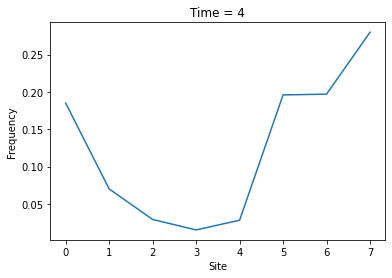

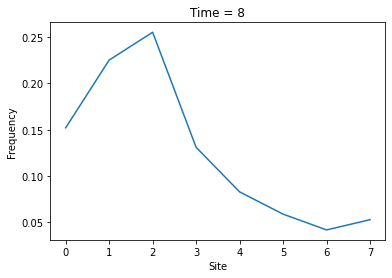

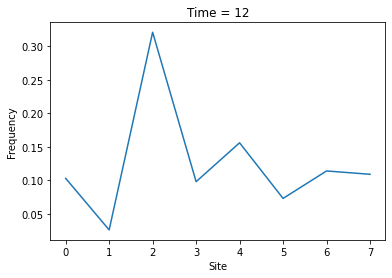

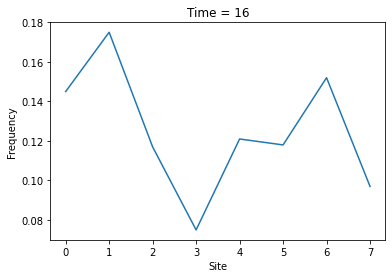

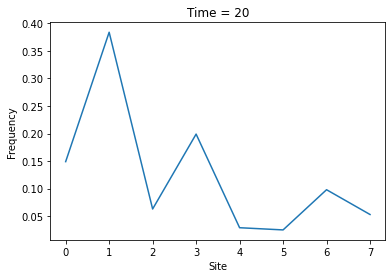

In [21]:
#Simulate using gate model - asymptotic precision

sim = cirq.Simulator()
counts = 1000 #Quantum measurement randomness
dt = 0.01 #Approximation error

for t in range(4,24,4):
    circuit = cirq.Circuit(HubbardModel(t, dt))
    sample = sim.run(circuit,repetitions=counts)
    data = sample.histogram(key='z')

    frequency = np.zeros(8)
    for key, value in data.items():
        site = int(np.log(key)/np.log(2))
        frequency[7-site] = int(value)
        
    frequency/=np.sum(frequency)#normalize
        
    plt.figure(t)
    plt.xlabel("Site")
    plt.ylabel("Frequency")
    plt.title("Time = "+str(t))
    plt.plot(frequency)

Run Time:  1


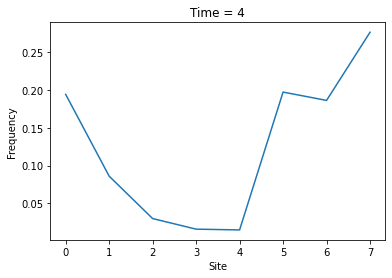

In [5]:
#Simulate using gate model
#What is the biggest step size that still gives a good approximation
#T=4: dt=0.04
#T=8: dt=0.003
#T=12: dt=0.005
#T=16: dt=0.0006
#T=20: dt = 0.0004

t=4 #evolution time
dt = 0.04 #Approximation error
counts = 1000 #Quantum measurement randomness

sim = cirq.Simulator()
circuit = cirq.Circuit(HubbardModel(t, dt))

#Time the simulation out of curiosity and boredom
start_time = timeit.default_timer()
sample = sim.run(circuit,repetitions=counts)#Simulate
elapsed = timeit.default_timer() - start_time
print("Run Time: ", int(elapsed))

data = sample.histogram(key='z')
frequency = np.zeros(8)
for key, value in data.items():
    site = int(np.log(key)/np.log(2))
    frequency[7-site] = int(value)

frequency/=np.sum(frequency)#normalize
    
plt.figure(t)
plt.xlabel("Site")
plt.ylabel("Frequency")
plt.title("Time = "+str(t))
plt.plot(frequency)

The largest step size for each evolution time with no noticeable approximation error:

| Evolution Time | dt |
| :------: | :------: |
| 4      | 0.04       |
| 8   | 0.003        |
| 12   | 0.005        |
| 16   | 0.0006        |
| 20   | 0.0004        |

# VQE - Heisenberg Antiferromagnet

$$
H_p = \sum_0^8 J(X_iX_{i+1}+Y_iY_{i+1}+Z_iZ_{i+1})
$$
$$
\langle H_p\rangle = \langle X_iX_{i+1}+Y_iY_{i+1}+Z_iZ_{i+1} \rangle = \langle XX\rangle+\langle YY\rangle+\langle ZZ\rangle
$$

In [7]:
#2a Measurement Circuits

#ZZ Measurement Circuit: You just measure them
def zz_measure(qubits):
    mlist =[]
    mlist.append(cirq.measure(*qubits, key='z'))
    return mlist

#XX Measurement Circuit:
def xx_measure(qubits):
    mlist =[]
    for q in qubits:
        mlist.append(cirq.H(q))
    mlist.append(cirq.measure(*qubits, key='z'))
    return mlist

#YY Measurement Circuit:
def yy_measure(qubits):
    mlist =[]
    for q in qubits:
        mlist.append(cirq.H(q))
        mlist.append(cirq.rz(np.pi/2)(q))
    mlist.append(cirq.measure(*qubits, key='z'))
    return mlist

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


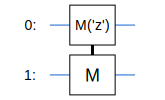

In [8]:
q = cirq.LineQubit.range(2)
SVGCircuit(cirq.Circuit(zz_measure(q)))

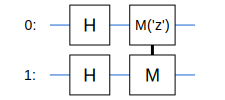

In [9]:
SVGCircuit(cirq.Circuit(xx_measure(q)))

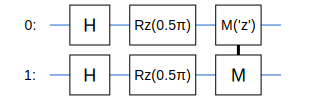

In [10]:
SVGCircuit(cirq.Circuit(yy_measure(q)))

In [11]:
#Measurement Functions
def ZZEnergy(state):
    adj_count = 0
    for i in range(len(state)-1):
        if state[i] == state[i+1]:
            adj_count += 1
        else:
            adj_count -= 1
    return adj_count

def key_to_state(key, L):#Convert key into binary format for list (binary list)
    binaryformat = "{0:0" + str(L) + "b}"
    bitstate = binaryformat.format(int(key))#Convert to binary to get the state as a string
    state = [0]*L
    for i in range(len(bitstate)):
        if bitstate[i] == '1':
            state[i] = 1
    return state

def EnergyExpectation(oplist, counts):
    sim = cirq.Simulator()
    circuit = cirq.Circuit(oplist)
    
    sample = sim.run(circuit, repetitions=counts)
    
    statelist = str(sample)[2:].split(", ")#list of states for each qubit
    L = len(statelist)#number of qubits
    energy_avg = 0
    #
    data = sample.histogram(key='z')
    for key, value in data.items():
        true_state = key_to_state(int(key), L)#Get the state it hit
        energy = ZZEnergy(true_state)#Get the energy
        energy_avg += energy * int(value)#Scale energy by occurrences
        
    energy_avg /= counts
    #
    '''Easier Alternative Method
    adj_count = 0
    for c in range(counts):#each run - no idea
        for q in range(L-1):#qubit iterator dont go over the edge
            if statelist[q][c] == statelist[q+1][c]:#adjacent qubit parity - should I subtract if they're different?
                adj_count += 1
            else:
                adj_count += -1
    energy_avg = adj_count / counts
    '''
    
    return energy_avg

$$
e^{-iH_pdt} = \prod_j e^{-iJdt(X_iX_{i+1}+Y_iY_{i+1})}e^{-iJdt(Z_iZ_{i+1})} = \prod_{j}\text{iSWAP}(\theta)\text{CPHASE}(\phi)R^z_j(-\phi)R^z_{j+1}(-\phi)
$$
$$
H_d = -V\sum_{j=0}^{L/2} Z_{2j},\: e^{-iH_ddt}=\prod_{2j} R^z_{j}(Vdt(1-s))
$$

In [24]:
#2b VQE Circuit

def HpLayer(qubits, dt, s):
    oplist = []
    J=1
    theta=-2*s*J*dt/np.pi
    phi = J*s*dt
    
    #2 layers of partial iswaps
    for i in range(len(qubits)):
        if i % 2 == 0 and i < len(qubits) - 1:#even bonds
            oplist.append(cirq.ISwapPowGate(exponent=theta)(qubits[i],qubits[i+1]))
            oplist.append(cirq.CZPowGate(exponent=phi)(qubits[i],qubits[i+1]))
            oplist.append(cirq.rz(phi)(qubits[i]))
            oplist.append(cirq.rz(phi)(qubits[i+1]))
            
    for i in range(len(qubits)):
        if i % 2 != 0 and i < len(qubits) - 1:#odd bonds
            oplist.append(cirq.ISwapPowGate(exponent=theta)(qubits[i],qubits[i+1]))
            oplist.append(cirq.CZPowGate(exponent=phi)(qubits[i],qubits[i+1]))
            oplist.append(cirq.rz(phi)(qubits[i]))
            oplist.append(cirq.rz(phi)(qubits[i+1]))
            
    return oplist

def HdLayer(qubits, dt, s):
    V=1
    oplist = []
    angle = -dt*V*2*(1-s)
    
    #Alternating Z
    for i in range(len(qubits)):
        if i % 2 == 0:
            oplist.append(cirq.rz(angle)(qubits[i]))
    return oplist

def f(x):
    return x

def makeVQE(T, P, qubits):
    dt = T/P
    ops = []
      
    #Initialization of L/2 particles at alternating sites
    for i in range(len(qubits)):
        if i % 2 == 0:
            ops.append(cirq.X(qubits[i]))
    
    #VQE Layers
    for k in range(P):
        s = f((k+1)/(P+1))#Why the +1?
        ops.append(HpLayer(qubits, dt, s))
        ops.append(HdLayer(qubits, dt, s))
    return ops

def HpEnergyMeasurement(qubits, T, P, counts):
    
    VQEcircuit = makeVQE(T, P, qubits)
    
    ##ZZ Measurement: number of expected 11s to appear
    zlist = VQEcircuit.copy()
    zlist.append(zz_measure(qubits))
    zz_expect = EnergyExpectation(zlist, counts)
    
    ##XX Measurement
    xxlist = VQEcircuit.copy()
    xxlist.append(xx_measure(qubits))
    xx_expect = EnergyExpectation(xxlist, counts)
    
    ##YY Measurement
    yylist = VQEcircuit.copy()
    yylist.append(yy_measure(qubits))
    yy_expect = EnergyExpectation(yylist, counts)
    
    #Total Expectation Value
    E_expect = (zz_expect-xx_expect-yy_expect)#cirq defines its gates badly hadamards have a negative phase
    
    print("Z:", zz_expect)
    print("Y:", -yy_expect)
    print("X:", -xx_expect)
    print("Expected Energy: ", E_expect)

In [25]:
#Run VQE for Heisenberg Antiferromagnet
qbits = cirq.LineQubit.range(8)
HpEnergyMeasurement(qbits, T=1, P=4, counts=10000)

Z: -4.5272
Y: -2.8366
X: -2.8742
Expected Energy:  -10.238


In [26]:
#2c ZZCorrelations
#01 12 23 34 45 56 67
#02 13 24 35 46 57
def CorrelationExpectation(oplist, counts):
    sim = cirq.Simulator()
    circuit = cirq.Circuit(oplist)
    
    sample = sim.run(circuit, repetitions=counts)
    
    statelist = str(sample)[2:].split(", ")#list of states for each qubit
    L = len(statelist)#number of qubits
    energy_avg = 0
    #Easier Alternative Method
    adj_count = np.zeros(7)
    hop_count = np.zeros(6)
    
    for c in range(counts):#each run - no idea
        for q in range(L-1):#qubit iterator dont go over the edge
            if statelist[q][c] == statelist[q+1][c]:#adjacent qubit parity
                adj_count[q] += 1
            else:
                adj_count[q] += -1
                
            if q < L-2:##Z_iZ_i+2
                if statelist[q][c] == statelist[q+2][c]:#adjacent qubit parity
                    hop_count[q] += 1
                else:
                    hop_count[q] += -1
                
    adj_avg = adj_count / counts
    hop_avg = hop_count / counts
    #'''
    
    return adj_avg, hop_avg

In [27]:
##ZZ Measurement for different correlations
VQEcircuit = makeVQE(1, 4, qbits)
corlist = VQEcircuit.copy()
corlist.append(zz_measure(qbits))
adj_avg, hop_avg = CorrelationExpectation(corlist, counts=1000)
print("Correlation Expectation Values <ZZ>")
print("01:%f 12:%f 23:%f 34:%f 45:%f 56:%f 67:%f\n"%tuple(adj_avg))
print("02:%f 13:%f 24:%f 35:%f 46:%f 57:%f"%tuple(hop_avg))

Correlation Expectation Values <ZZ>
01:-0.816000 12:-0.518000 23:-0.696000 34:-0.512000 45:-0.696000 56:-0.406000 67:-0.836000

02:0.334000 13:0.262000 24:0.252000 35:0.272000 46:0.202000 57:0.242000
